# Modelagem dos dados

In [1]:
import math
import keras
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats
from sklearn import preprocessing

Using TensorFlow backend.


### Leitura dos dados

In [2]:
df = pd.read_csv("./../winequality.csv", sep=";")
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,White,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,White,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,White,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


### Vejamos os tipos de dados de cada coluna

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6497 non-null   float64
 2   volatile acidity      6497 non-null   float64
 3   citric acid           6497 non-null   float64
 4   residual sugar        6497 non-null   float64
 5   chlorides             6497 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6497 non-null   float64
 10  sulphates             6497 non-null   float64
 11  alcohol               6497 non-null   object 
 12  quality               6497 non-null   int64  
dtypes: float64(10), int64(1), object(2)
memory usage: 660.0+ KB


### TRATAMENTO DO BANCO DE DADOS

Se observado os dados type e alcohol são objects, precisamos só trabalhar com números.

* type: object (vamos mudar para inteiro)
* alcohol: object (vamos mudar para float e eliminar dados incosistentes)

In [4]:
#adicionar números como representantes das categorias
df['type'] = df['type'].map( {'White': 1, 'Red': 0} ).astype(int)
#vamos corrigir os erros da coluna, e substituí-los para NaN, em seguida preencher essas lacunas com a moda
#poderiamos ignorá-los, mas cada dado é valioso e vamos investigar usando essas dados corrompidos
df['alcohol'] = pd.to_numeric(df['alcohol'], errors='coerce')
freq_port = df.alcohol.dropna().mode()[0]
df['alcohol'] = df['alcohol'].fillna(freq_port)

### Agora os dados são apenas números!!!

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   int64  
 1   fixed acidity         6497 non-null   float64
 2   volatile acidity      6497 non-null   float64
 3   citric acid           6497 non-null   float64
 4   residual sugar        6497 non-null   float64
 5   chlorides             6497 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6497 non-null   float64
 10  sulphates             6497 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 660.0 KB


In [6]:
# vamos remover a informação de qualidade para normalizar, depois vamos recoloca-la
quality_serie = df['quality']
df = df[:-1]

### Esse é um caso interessante, vamos adicionar um atributo relacionado a proporção de dioxide, adicionado como joy example para mostrar que algumas derivações de atributos foram avaliadas. Foi percebido essa possibilidade no final da análise, porém o melhor momento de adicionar é antes da normalização.

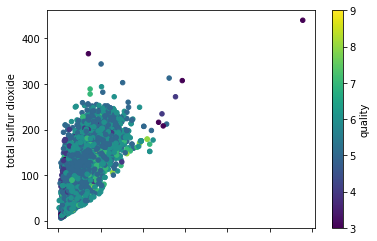

In [7]:
# Adiciono uma nova variável com a proporção de dioxide
df['prop dioxide'] = df['free sulfur dioxide']/df['total sulfur dioxide']

ax2 = df.plot.scatter(x='free sulfur dioxide',
                      y='total sulfur dioxide',
                      c='quality',
                      colormap='viridis')

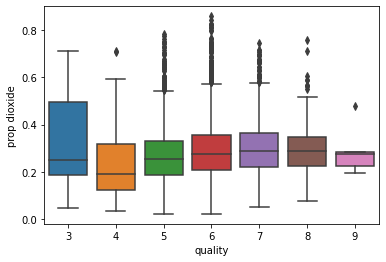

In [8]:
ax3 = sns.boxplot(x="quality", y="prop dioxide", data=df)

### Para começar a análise, vamos ver como a distribuição dos dados se dá

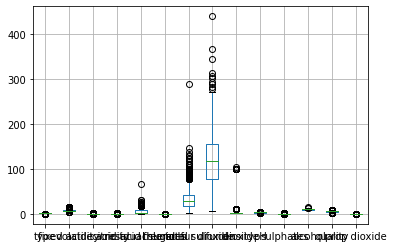

In [9]:
df.boxplot(column=list(df.columns))

### Percebe-se que alguns atributos tem valores discrepantes, para melhorar essa visualização e não enviesar nossos modelos (alguns podem ser enviesados por essa discrepâcia de valores), vamos normalizar esses dados.

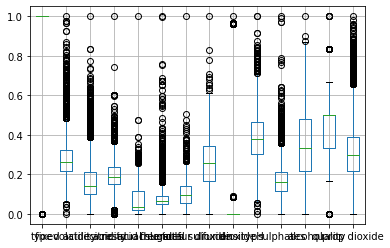

In [10]:
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_normalized = pd.DataFrame(x_scaled, columns=df.columns)
df = df_normalized

df.boxplot(column=list(df.columns))

### Como podem ver, alguns atributos tem outliers, vamos remove-los.

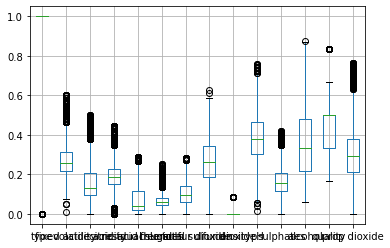

In [11]:
#REMOVER OUTLIERS
z_scores = stats.zscore(df) #calculate z-scores of `df` média 0 desvio padrão 1
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
df_without_outliers = df[filtered_entries]

df_without_outliers.boxplot(column=list(df.columns))

In [12]:
df['quality'] = quality_serie
df_without_outliers[['quality', 'type']].groupby(['quality'], as_index=False).mean().sort_values(by='quality', ascending=False)

,quality,type
4,0.833333,0.939560
3,0.666667,0.856299
2,0.500000,0.816563
1,0.333333,0.720352
0,0.166667,0.836957


### Ao remover os outliers, percebemos que os dados de qualidade 3 e 9 são removidos, então eles são relevantes e devem permanecer junto com os dados.

### Agora vamos ver como o atributo quality está distribuido na coluna type novamente, mas com outra perspectiva.

In [13]:
df[['quality', 'type']].groupby(['quality'], as_index=False).mean().sort_values(by='quality', ascending=False)

,quality,type
6,9,1.000000
5,8,0.906736
4,7,0.815570
3,6,0.775309
2,5,0.681478
1,4,0.754630
0,3,0.666667


### Atributo type parece mostrar que a incidência de vinhos de qualidade maior estão mais presentes no vinho branco. Isso se deve também a quantidade de vinhos Brancos que são sua maioria.

### Vamos interpretar atributo por atributo.

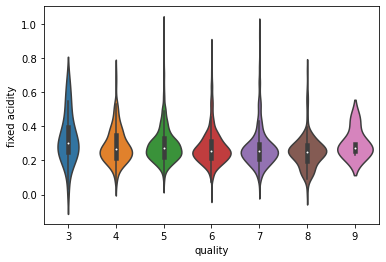

In [14]:
ax = sns.violinplot(x="quality", y="fixed acidity", data=df)

### Esse atributo não parece ser muito descritivo porém, para os casos de qualidade 3 e 9, eles se dirvegem com uma barriga maior (maior frequência dos dados) nos vinhos de alta qualidade.

### Vamos ao próximo atributo.

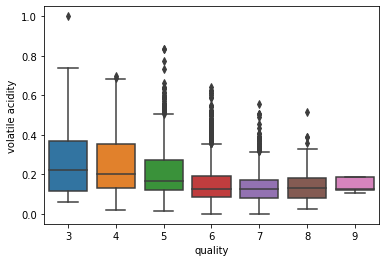

In [15]:
ax = sns.boxplot(x="quality", y="volatile acidity", data=df)

### Esse atributo já mostrou uma variedada correlacionada a qualidade, apesar de pouca.

### Vamos ao próximo:

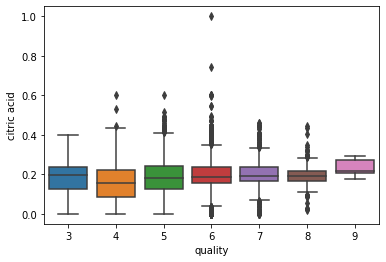

In [16]:
ax = sns.boxplot(x="quality", y="citric acid", data=df)

### Isoladamente não parece um bom atributo, mas podemos ver quando ele se combina com outro, sempre que isso ocorre, separamos esses casos para aumentar ou diminuir a dimensionalidade e verificar correlações, por enquanto mantemos.

### Segue o residual sugar

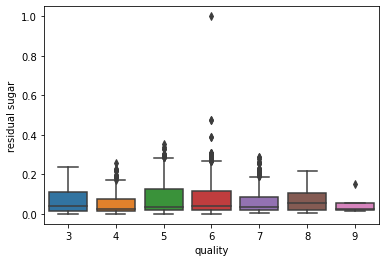

In [17]:
ax = sns.boxplot(x="quality", y="residual sugar", data=df)

### Mesma situação do anterior citric acid

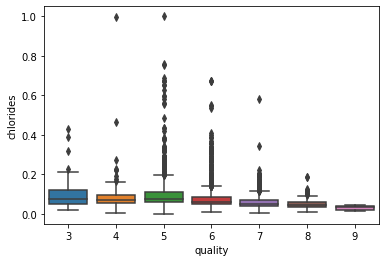

In [18]:
ax = sns.boxplot(x="quality", y="chlorides", data=df)

### Sutilmente os vinhos com mais qualidade estão em um intervalo mais curto

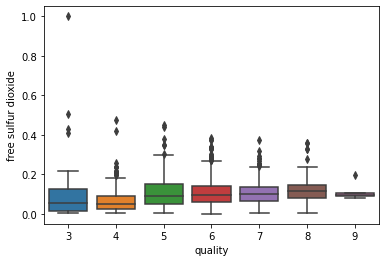

In [19]:
ax = sns.boxplot(x="quality", y="free sulfur dioxide", data=df)

### Estreitamento do intervalo em vinhos com mais qualidade.

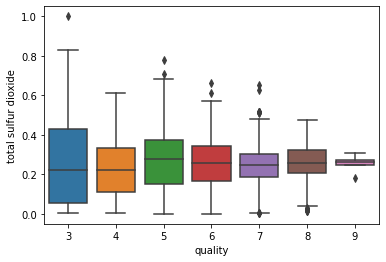

In [20]:
ax = sns.boxplot(x="quality", y="total sulfur dioxide", data=df)

### Algumas características só aparecem em vinhos com qualidade inferior, o intervalo fica mais concentrados a medida que a qualidade aumenta.

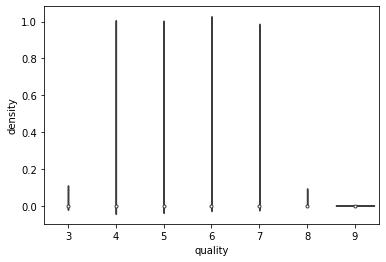

In [21]:
ax = sns.violinplot(x="quality", y="density", data=df)

### Variação inconsistente, os valores aparecem sem seguir crescente estável, nesses casos vamos categorizar por alguns intervalos.

In [22]:
# vamos categorizar, agrupar alguns intervalos
df.loc[ df['density'] <= 0.2, 'density'] = 0
df.loc[(df['density'] > 0.2) & (df['density'] <= 0.6), 'density'] = 0.5
df.loc[ df['density'] > 0.6, 'density'] = 1
df['density'] = df['density'].astype(int)
df[['quality', 'density']].groupby(['quality'], as_index=False).mean().sort_values(by='quality', ascending=False)

,quality,density
6,9,0.000000
5,8,0.000000
4,7,0.002780
3,6,0.005291
2,5,0.008887
1,4,0.004630
0,3,0.000000


### Vinhos com densidade maior são representados com pior qualidade, com algumas exceções, inclusive para os vinhos de pior qualidade, o que dificulta na discriminação da amostra.

### Vamos a próxima característica:

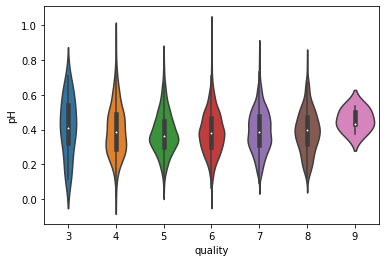

In [23]:
ax = sns.violinplot(x="quality", y="pH", data=df)

### Quanto maior a qualidade, mais restrito são os valores aceitáveis de ph do vinho

### Vamos a próxima característica:

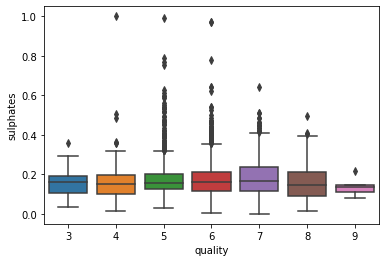

In [24]:
ax = sns.boxplot(x="quality", y="sulphates", data=df)

### Não parece ser um bom atributo, porém delimita subconjuntos simples (3 e 9), (7 e 8) e (4, 5 e 6)

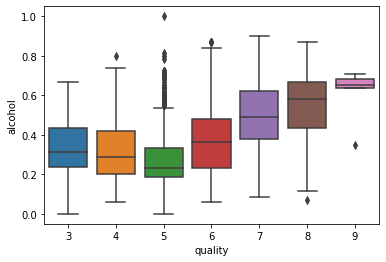

In [25]:
ax = sns.boxplot(x="quality", y="alcohol", data=df)

### Ótimo atributo, mostra-se bom representante para bons vinhos

### Agora vamos separar os atributos ruins e intercala-los com outros atributos para ver se encontra algum padrão para representar bons vinhos:

### Vamos começar com 

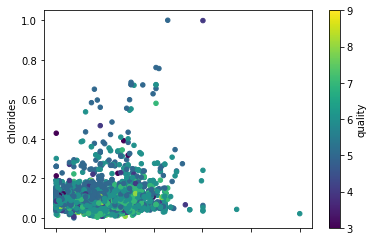

In [26]:
ax2 = df.plot.scatter(x='citric acid',
                      y='chlorides',
                      c='quality',
                      colormap='viridis')

### Isoladamente não parece um bom preditor, mas quando combinado com chlorides, parece ter algum potencial, ver-se que os melhores qualificados vinhos estão na parte inferior do gráfico, apesar de sutil.

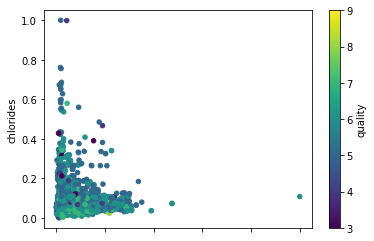

In [27]:
ax2 = df.plot.scatter(x='residual sugar',
                      y='chlorides',
                      c='quality',
                      colormap='viridis')

### Isoladamente não parece um bom preditor, mas quando combinado com chlorides, um sutil correlação acontece. Quanto mais distante da região inferior esquerda, menor a qualidade do vinho.

### Assim, pelo que foi analisado, vamos manter todos os atributos com o acréscimo de mais um.

# Machine Learning

In [28]:
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

### Vamos selecionar nossas técnicas

In [29]:
machine_learning_techniques = []
machine_learning_techniques.append(SVC())
machine_learning_techniques.append(LinearSVC())
machine_learning_techniques.append(RandomForestClassifier())
machine_learning_techniques.append(KNeighborsClassifier())
machine_learning_techniques.append(GaussianNB())
machine_learning_techniques.append(Perceptron())
machine_learning_techniques.append(SGDClassifier())
machine_learning_techniques.append(DecisionTreeClassifier())
machine_learning_techniques.append(MultinomialNB())

### Embaralhar nossa amostra

In [30]:
df = df.sample(frac=1).reset_index(drop=True)

### Treinar e avaliar nossos modelos

In [31]:
for tech in machine_learning_techniques:

    # cross 10-fold validation
    interval = int(len(df)/10)
    total_acc = []
    total_rmse = []
    for i in range(0, len(df)-interval, interval):

        test_df = df.loc[i:i+interval]
        if i+interval > len(df)-interval:
            test_df = df.loc[i:]

        train_df = df.drop(test_df.index)
        # Balanceamento não melhorou a predição dos modelos e por isso não foi utilizado, seguimos com a distribuição reais dos dados.
        # train_df = balancing(train_df)

        X_test = test_df.drop("quality", axis=1)
        Y_test = test_df["quality"]

        X_train = train_df.drop("quality", axis=1)
        Y_train = train_df["quality"]

        # treina
        tech.fit(X_train, Y_train)
        
        # predição e acc
        Y_pred = tech.predict(X_test)
        
        acc_tech = round(tech.score(X_test, Y_test) * 100, 2)
        mse = mean_squared_error(Y_test, Y_pred)
        # print(f'acc: {acc_tech} mse:{mse}')
        total_acc.append(acc_tech)
        total_rmse.append(mse)

    acc_mean = sum(total_acc)/len(total_acc)
    rmse_mean = sum(total_rmse)/len(total_rmse)
    print(f'acc: {round(acc_mean, 2)}% - rmse: {round(rmse_mean, 2)} {tech.__class__.__name__}')

acc: 54.56% - rmse: 0.63 SVC
acc: 53.38% - rmse: 0.66 LinearSVC
acc: 70.55% - rmse: 0.41 RandomForestClassifier
acc: 57.19% - rmse: 0.65 KNeighborsClassifier
acc: 2.01% - rmse: 6.54 GaussianNB
acc: 46.92% - rmse: 0.89 Perceptron
acc: 50.47% - rmse: 0.76 SGDClassifier
acc: 62.98% - rmse: 0.67 DecisionTreeClassifier
acc: 43.82% - rmse: 0.79 MultinomialNB


# Deep Learning

In [32]:
import keras
import keras.backend as K
import pandas as pd
import matplotlib.pyplot as plt

from keras.utils import np_utils

### Definição do modelo

In [33]:
model = keras.Sequential([
    keras.layers.Dense(128, activation='elu', input_shape=(13,)),
    keras.layers.Dense(64, activation='elu'),
    keras.layers.Dense(32, activation='elu'),
    keras.layers.Dense(16, activation='elu'),
    keras.layers.Dense(7, activation='softmax')
])

### Criação de uma callback

In [34]:
from keras.callbacks import Callback

class TerminateTrainingLoss(Callback):

    """
    Termina o treino quando atinge determinada loss
    """

    def __init__(self, minimal_loss=0.2):
        self.minimal_loss = minimal_loss

    def on_epoch_end(self, epoch, logs=None, verbose=False):
        
        if logs.get('loss') < self.minimal_loss:
            self.model.stop_training = True

### Criação de uma loss function para observação

In [35]:
def RMSE(y_true, y_pred):
    # Um pouco diferente da abordagem do sklearn por que utiliza das probabilidades da softmax 
    # (não comparável até que se utilizem a mesma abordagem para avaliação)
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

adam = keras.optimizers.Adam(learning_rate=0.004)
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['acc', RMSE])

### Preparação dos dados

In [36]:
df = df.sample(frac=1).reset_index(drop=True)
interval = int(len(df)/10)
print(f'interval: {interval}')

test_df = df.loc[:interval]
train_df = df.drop(test_df.index)
# Balanceamento não melhorou a predição dos modelos e por isso não foi utilizado, seguimos com a distribuição reais dos dados.
# train_df = balancing(train_df)

# Como parte do pré processamento vamos transformar o label em matriz identidade
# por isso vamos simplificar o valor desse resultado para um intervalo melhor aceitável
# entre 0 e 7 e não entre 3 e 9
X_test = test_df.drop("quality", axis=1)
Y_test = test_df["quality"]-3

X_train = train_df.drop("quality", axis=1)
Y_train = train_df["quality"]-3

print(np_utils.to_categorical(Y_test).shape)

interval: 649
(650, 6)


### Treino e avaliação do modelo

In [37]:
# callback
callback = TerminateTrainingLoss()

# treina
history = model.fit(X_train, 
                    np_utils.to_categorical(Y_train, num_classes=7), 
                    epochs=1000, 
                    callbacks=[callback],
                    verbose=1, 
                    batch_size=128, 
                    validation_split = 0.1)

# predição e acc e mse
_, acc_tech, _ = model.evaluate(X_test, 
                            np_utils.to_categorical(Y_test, num_classes=7), 
                            verbose=0)

print(f'\nDeep learning trouxe uma acurácia de {round(acc_tech,2)}\n')

Train on 5261 samples, validate on 585 samples
Epoch 1/1000
5261/5261 [==============================] - 0s 41us/step - loss: 1.2935 - acc: 0.4592 - RMSE: 0.3051 - val_loss: 1.1066 - val_acc: 0.5419 - val_RMSE: 0.2915
Epoch 2/1000
5261/5261 [==============================] - 0s 17us/step - loss: 1.1183 - acc: 0.5183 - RMSE: 0.2922 - val_loss: 1.1031 - val_acc: 0.5316 - val_RMSE: 0.2911
Epoch 3/1000
5261/5261 [==============================] - 0s 18us/step - loss: 1.1029 - acc: 0.5227 - RMSE: 0.2917 - val_loss: 1.0743 - val_acc: 0.5094 - val_RMSE: 0.2895
Epoch 4/1000
5261/5261 [==============================] - 0s 17us/step - loss: 1.0995 - acc: 0.5305 - RMSE: 0.2936 - val_loss: 1.0835 - val_acc: 0.5453 - val_RMSE: 0.2893
Epoch 5/1000
5261/5261 [==============================] - 0s 15us/step - loss: 1.0943 - acc: 0.5366 - RMSE: 0.2912 - val_loss: 1.0703 - val_acc: 0.5453 - val_RMSE: 0.2884
Epoch 6/1000
5261/5261 [==============================] - 0s 15us/step - loss: 1.0873 - acc: 0.531

5261/5261 [==============================] - 0s 13us/step - loss: 1.0003 - acc: 0.5680 - RMSE: 0.2828 - val_loss: 1.0054 - val_acc: 0.5436 - val_RMSE: 0.2815
Epoch 49/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.9815 - acc: 0.5769 - RMSE: 0.2794 - val_loss: 1.0210 - val_acc: 0.5333 - val_RMSE: 0.2844
Epoch 50/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.9861 - acc: 0.5750 - RMSE: 0.2803 - val_loss: 1.0073 - val_acc: 0.5607 - val_RMSE: 0.2814
Epoch 51/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.9932 - acc: 0.5670 - RMSE: 0.2816 - val_loss: 1.0163 - val_acc: 0.5470 - val_RMSE: 0.2831
Epoch 52/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.9801 - acc: 0.5778 - RMSE: 0.2803 - val_loss: 1.0070 - val_acc: 0.5521 - val_RMSE: 0.2826
Epoch 53/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.9900 - acc: 0.5695 - RMSE: 0.2806 - val_loss: 1.0020 - val_acc: 0.5795 -

Epoch 96/1000
5261/5261 [==============================] - 0s 14us/step - loss: 0.8837 - acc: 0.6159 - RMSE: 0.2677 - val_loss: 1.0564 - val_acc: 0.5590 - val_RMSE: 0.2844
Epoch 97/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.8772 - acc: 0.6178 - RMSE: 0.2673 - val_loss: 1.0445 - val_acc: 0.5829 - val_RMSE: 0.2804
Epoch 98/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.8831 - acc: 0.6126 - RMSE: 0.2686 - val_loss: 1.0137 - val_acc: 0.5966 - val_RMSE: 0.2781
Epoch 99/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.8693 - acc: 0.6193 - RMSE: 0.2660 - val_loss: 1.0199 - val_acc: 0.5658 - val_RMSE: 0.2776
Epoch 100/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.8802 - acc: 0.6204 - RMSE: 0.2689 - val_loss: 1.0589 - val_acc: 0.5675 - val_RMSE: 0.2810
Epoch 101/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.8708 - acc: 0.6189 - RMSE: 0.2669 - val_loss: 1.0303 - v

5261/5261 [==============================] - 0s 13us/step - loss: 0.7625 - acc: 0.6717 - RMSE: 0.2498 - val_loss: 1.1253 - val_acc: 0.5726 - val_RMSE: 0.2806
Epoch 144/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.7539 - acc: 0.6734 - RMSE: 0.2485 - val_loss: 1.1337 - val_acc: 0.5812 - val_RMSE: 0.2814
Epoch 145/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.7442 - acc: 0.6740 - RMSE: 0.2489 - val_loss: 1.1297 - val_acc: 0.5744 - val_RMSE: 0.2831
Epoch 146/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.7511 - acc: 0.6755 - RMSE: 0.2484 - val_loss: 1.1160 - val_acc: 0.5778 - val_RMSE: 0.2842
Epoch 147/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.7446 - acc: 0.6786 - RMSE: 0.2474 - val_loss: 1.1084 - val_acc: 0.5966 - val_RMSE: 0.2787
Epoch 148/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.7310 - acc: 0.6839 - RMSE: 0.2462 - val_loss: 1.1652 - val_acc: 0.5

5261/5261 [==============================] - 0s 13us/step - loss: 0.6465 - acc: 0.7284 - RMSE: 0.2297 - val_loss: 1.3197 - val_acc: 0.5761 - val_RMSE: 0.2888
Epoch 191/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.6429 - acc: 0.7297 - RMSE: 0.2287 - val_loss: 1.3278 - val_acc: 0.5675 - val_RMSE: 0.2897
Epoch 192/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.6424 - acc: 0.7221 - RMSE: 0.2311 - val_loss: 1.3554 - val_acc: 0.5795 - val_RMSE: 0.2910
Epoch 193/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.6192 - acc: 0.7404 - RMSE: 0.2256 - val_loss: 1.2978 - val_acc: 0.5726 - val_RMSE: 0.2886
Epoch 194/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.6372 - acc: 0.7310 - RMSE: 0.2282 - val_loss: 1.3620 - val_acc: 0.5761 - val_RMSE: 0.2908
Epoch 195/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.6308 - acc: 0.7375 - RMSE: 0.2278 - val_loss: 1.3524 - val_acc: 0.5

5261/5261 [==============================] - 0s 13us/step - loss: 0.5352 - acc: 0.7826 - RMSE: 0.2107 - val_loss: 1.4917 - val_acc: 0.5726 - val_RMSE: 0.2985
Epoch 238/1000
5261/5261 [==============================] - 0s 14us/step - loss: 0.5956 - acc: 0.7573 - RMSE: 0.2199 - val_loss: 1.5028 - val_acc: 0.5829 - val_RMSE: 0.2925
Epoch 239/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.6239 - acc: 0.7518 - RMSE: 0.2205 - val_loss: 1.4893 - val_acc: 0.5778 - val_RMSE: 0.2973
Epoch 240/1000
5261/5261 [==============================] - 0s 14us/step - loss: 0.5667 - acc: 0.7630 - RMSE: 0.2166 - val_loss: 1.5274 - val_acc: 0.5726 - val_RMSE: 0.2971
Epoch 241/1000
5261/5261 [==============================] - 0s 14us/step - loss: 0.5627 - acc: 0.7694 - RMSE: 0.2126 - val_loss: 1.5322 - val_acc: 0.5761 - val_RMSE: 0.2946
Epoch 242/1000
5261/5261 [==============================] - 0s 14us/step - loss: 0.5298 - acc: 0.7831 - RMSE: 0.2079 - val_loss: 1.5481 - val_acc: 0.5

5261/5261 [==============================] - 0s 13us/step - loss: 0.4809 - acc: 0.7991 - RMSE: 0.1994 - val_loss: 1.7416 - val_acc: 0.5983 - val_RMSE: 0.2945
Epoch 285/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.5186 - acc: 0.7909 - RMSE: 0.2031 - val_loss: 1.7129 - val_acc: 0.5744 - val_RMSE: 0.2951
Epoch 286/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.4664 - acc: 0.8035 - RMSE: 0.1950 - val_loss: 1.6796 - val_acc: 0.5915 - val_RMSE: 0.2962
Epoch 287/1000
5261/5261 [==============================] - 0s 14us/step - loss: 0.4590 - acc: 0.8082 - RMSE: 0.1933 - val_loss: 1.7195 - val_acc: 0.5812 - val_RMSE: 0.2990
Epoch 288/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.4757 - acc: 0.8054 - RMSE: 0.1965 - val_loss: 1.8204 - val_acc: 0.5949 - val_RMSE: 0.2941
Epoch 289/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.4614 - acc: 0.8084 - RMSE: 0.1938 - val_loss: 1.7512 - val_acc: 0.6

5261/5261 [==============================] - 0s 13us/step - loss: 0.4230 - acc: 0.8249 - RMSE: 0.1870 - val_loss: 1.9682 - val_acc: 0.6068 - val_RMSE: 0.2949
Epoch 332/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.5738 - acc: 0.7913 - RMSE: 0.2040 - val_loss: 1.8752 - val_acc: 0.5915 - val_RMSE: 0.2946
Epoch 333/1000
5261/5261 [==============================] - 0s 16us/step - loss: 0.5055 - acc: 0.7964 - RMSE: 0.2004 - val_loss: 1.8902 - val_acc: 0.5949 - val_RMSE: 0.2977
Epoch 334/1000
5261/5261 [==============================] - 0s 18us/step - loss: 0.4421 - acc: 0.8246 - RMSE: 0.1888 - val_loss: 1.9250 - val_acc: 0.6103 - val_RMSE: 0.2910
Epoch 335/1000
5261/5261 [==============================] - 0s 15us/step - loss: 0.4274 - acc: 0.8240 - RMSE: 0.1865 - val_loss: 1.8530 - val_acc: 0.6000 - val_RMSE: 0.2996
Epoch 336/1000
5261/5261 [==============================] - 0s 14us/step - loss: 0.4248 - acc: 0.8293 - RMSE: 0.1849 - val_loss: 1.9573 - val_acc: 0.6

5261/5261 [==============================] - 0s 13us/step - loss: 0.3662 - acc: 0.8525 - RMSE: 0.1720 - val_loss: 2.1766 - val_acc: 0.6342 - val_RMSE: 0.2971
Epoch 379/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.3535 - acc: 0.8601 - RMSE: 0.1669 - val_loss: 2.0656 - val_acc: 0.5829 - val_RMSE: 0.3056
Epoch 380/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.3401 - acc: 0.8669 - RMSE: 0.1646 - val_loss: 2.1845 - val_acc: 0.5983 - val_RMSE: 0.3008
Epoch 381/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.3436 - acc: 0.8637 - RMSE: 0.1677 - val_loss: 2.0546 - val_acc: 0.6068 - val_RMSE: 0.3014
Epoch 382/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.3631 - acc: 0.8590 - RMSE: 0.1725 - val_loss: 2.0939 - val_acc: 0.5863 - val_RMSE: 0.3031
Epoch 383/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.3979 - acc: 0.8411 - RMSE: 0.1797 - val_loss: 2.1151 - val_acc: 0.6

5261/5261 [==============================] - 0s 13us/step - loss: 0.3410 - acc: 0.8622 - RMSE: 0.1655 - val_loss: 2.3917 - val_acc: 0.6188 - val_RMSE: 0.2995
Epoch 426/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.3615 - acc: 0.8521 - RMSE: 0.1728 - val_loss: 2.4430 - val_acc: 0.6000 - val_RMSE: 0.3063
Epoch 427/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.3703 - acc: 0.8550 - RMSE: 0.1736 - val_loss: 2.3385 - val_acc: 0.6000 - val_RMSE: 0.3047
Epoch 428/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.4807 - acc: 0.8287 - RMSE: 0.1869 - val_loss: 2.2872 - val_acc: 0.6154 - val_RMSE: 0.3000
Epoch 429/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.4252 - acc: 0.8325 - RMSE: 0.1844 - val_loss: 2.3371 - val_acc: 0.5897 - val_RMSE: 0.3079
Epoch 430/1000
5261/5261 [==============================] - 0s 14us/step - loss: 0.3744 - acc: 0.8512 - RMSE: 0.1728 - val_loss: 2.5602 - val_acc: 0.6

5261/5261 [==============================] - 0s 13us/step - loss: 0.3368 - acc: 0.8645 - RMSE: 0.1642 - val_loss: 2.3372 - val_acc: 0.6205 - val_RMSE: 0.3001
Epoch 473/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.3068 - acc: 0.8806 - RMSE: 0.1586 - val_loss: 2.4295 - val_acc: 0.6017 - val_RMSE: 0.2999
Epoch 474/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.4136 - acc: 0.8453 - RMSE: 0.1747 - val_loss: 2.3667 - val_acc: 0.6171 - val_RMSE: 0.3021
Epoch 475/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.3102 - acc: 0.8803 - RMSE: 0.1558 - val_loss: 2.3974 - val_acc: 0.6205 - val_RMSE: 0.2993
Epoch 476/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.2935 - acc: 0.8856 - RMSE: 0.1526 - val_loss: 2.3860 - val_acc: 0.6325 - val_RMSE: 0.2975
Epoch 477/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.3037 - acc: 0.8795 - RMSE: 0.1549 - val_loss: 2.4138 - val_acc: 0.6

5261/5261 [==============================] - 0s 14us/step - loss: 0.3402 - acc: 0.8734 - RMSE: 0.1632 - val_loss: 2.9476 - val_acc: 0.5846 - val_RMSE: 0.3129
Epoch 520/1000
5261/5261 [==============================] - 0s 14us/step - loss: 0.3633 - acc: 0.8580 - RMSE: 0.1682 - val_loss: 2.5481 - val_acc: 0.6000 - val_RMSE: 0.3082
Epoch 521/1000
5261/5261 [==============================] - 0s 14us/step - loss: 0.3337 - acc: 0.8647 - RMSE: 0.1650 - val_loss: 2.6432 - val_acc: 0.6000 - val_RMSE: 0.3057
Epoch 522/1000
5261/5261 [==============================] - 0s 14us/step - loss: 0.3559 - acc: 0.8561 - RMSE: 0.1677 - val_loss: 2.8798 - val_acc: 0.5915 - val_RMSE: 0.3114
Epoch 523/1000
5261/5261 [==============================] - 0s 17us/step - loss: 0.3243 - acc: 0.8694 - RMSE: 0.1588 - val_loss: 2.8637 - val_acc: 0.6154 - val_RMSE: 0.3076
Epoch 524/1000
5261/5261 [==============================] - 0s 16us/step - loss: 0.2924 - acc: 0.8846 - RMSE: 0.1518 - val_loss: 2.7161 - val_acc: 0.6

5261/5261 [==============================] - 0s 13us/step - loss: 0.2543 - acc: 0.9036 - RMSE: 0.1399 - val_loss: 2.7927 - val_acc: 0.6222 - val_RMSE: 0.3059
Epoch 567/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.2539 - acc: 0.9027 - RMSE: 0.1416 - val_loss: 3.0653 - val_acc: 0.6034 - val_RMSE: 0.3114
Epoch 568/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.2804 - acc: 0.8939 - RMSE: 0.1496 - val_loss: 3.0080 - val_acc: 0.5949 - val_RMSE: 0.3088
Epoch 569/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.3837 - acc: 0.8557 - RMSE: 0.1694 - val_loss: 3.1081 - val_acc: 0.5829 - val_RMSE: 0.3120
Epoch 570/1000
5261/5261 [==============================] - 0s 14us/step - loss: 0.3545 - acc: 0.8658 - RMSE: 0.1641 - val_loss: 3.3247 - val_acc: 0.6103 - val_RMSE: 0.3079
Epoch 571/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.3306 - acc: 0.8647 - RMSE: 0.1622 - val_loss: 3.2693 - val_acc: 0.5

5261/5261 [==============================] - 0s 13us/step - loss: 0.2599 - acc: 0.9010 - RMSE: 0.1447 - val_loss: 2.8852 - val_acc: 0.6085 - val_RMSE: 0.3066
Epoch 614/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.2747 - acc: 0.8934 - RMSE: 0.1470 - val_loss: 2.8619 - val_acc: 0.6051 - val_RMSE: 0.3081
Epoch 615/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.2484 - acc: 0.9038 - RMSE: 0.1414 - val_loss: 2.9465 - val_acc: 0.6137 - val_RMSE: 0.3027
Epoch 616/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.2581 - acc: 0.8974 - RMSE: 0.1428 - val_loss: 3.0020 - val_acc: 0.6188 - val_RMSE: 0.3042
Epoch 617/1000
5261/5261 [==============================] - 0s 14us/step - loss: 0.2714 - acc: 0.8939 - RMSE: 0.1471 - val_loss: 2.9591 - val_acc: 0.6154 - val_RMSE: 0.3060
Epoch 618/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.2760 - acc: 0.8892 - RMSE: 0.1482 - val_loss: 2.8669 - val_acc: 0.6

5261/5261 [==============================] - 0s 13us/step - loss: 0.3632 - acc: 0.8601 - RMSE: 0.1642 - val_loss: 3.0813 - val_acc: 0.6051 - val_RMSE: 0.3096
Epoch 661/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.2767 - acc: 0.8884 - RMSE: 0.1496 - val_loss: 3.1117 - val_acc: 0.6103 - val_RMSE: 0.3072
Epoch 662/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.2699 - acc: 0.8964 - RMSE: 0.1450 - val_loss: 3.3309 - val_acc: 0.6085 - val_RMSE: 0.3082
Epoch 663/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.2570 - acc: 0.9012 - RMSE: 0.1421 - val_loss: 3.4250 - val_acc: 0.6085 - val_RMSE: 0.3106
Epoch 664/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.2389 - acc: 0.9105 - RMSE: 0.1367 - val_loss: 3.2241 - val_acc: 0.6068 - val_RMSE: 0.3106
Epoch 665/1000
5261/5261 [==============================] - 0s 13us/step - loss: 0.2407 - acc: 0.9091 - RMSE: 0.1362 - val_loss: 3.2429 - val_acc: 0.6

### Vamos plotar o histórico de treinamento

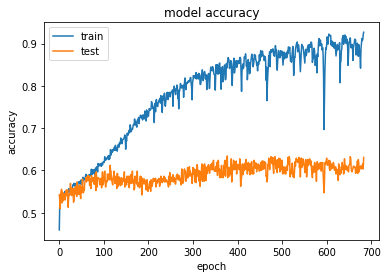

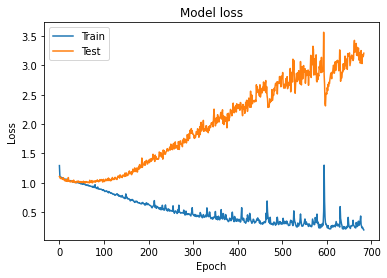

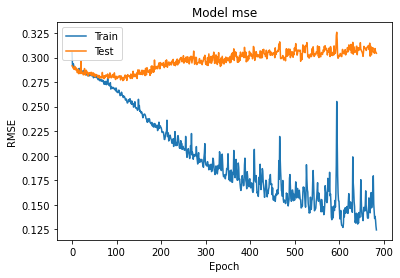

In [38]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation mse values
plt.plot(history.history['RMSE'])
plt.plot(history.history['val_RMSE'])
plt.title('Model mse')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()